# Extract Roget Thesaurus

In [1]:
import os

file_read = open("/home/moamin/git_projects/dataset_corpus/roget_words/ROGET.CAT")
count = 0

class_hash = {}
sub_category_hash = {}
category_hash = {}
word_hash = {}
word_list = []

for line in file_read:  
    line = line.strip().lower()
    
    if line.startswith("class") and "-" in line:
        class_name = line
        class_hash[class_name] = True
        count += 1
        continue
        
    if not line[0].isdigit():
        if not "(" in line:
            count += 1
            print(count, line)
            continue
        
        word_detail = category_detail + "#" + line
        if not word_detail in word_hash:
            word_hash[word_detail] = 0
            #word_list.append(word_detail)
            word_list.append([category_detail, line])
            count += 1
        else:
            count += 1
            print(count, line)
            
        word_hash[word_detail] += 1
        #print(word_detail)
        #count += 1
        continue
    
    words = line.split()
    #if not len(words) == 2:
    #    continue

    if "." in words[0]:
        class_name = class_name + "#" + line
        if not class_name in sub_category_hash:
            sub_category_hash[class_name] = 0
            count += 1
            
        sub_category_hash[class_name] += 1
        #count += 1
        continue
        
    #if "_" in words[0]:
    #    continue
    #if "(" in words[1]:
    #    continue

    category_detail = class_name + "#" + line #words[1]

    if not category_detail in category_hash:
        category_hash[category_detail] = 0
        count += 1
    category_hash[category_detail] += 1
    
    continue
    
    print(category_detail)
    count += 1
    
    if count == 10:
        break
        
print(len(class_hash), len(sub_category_hash), len(category_hash), len(word_hash))
print(len(class_hash) + len(sub_category_hash) + len(category_hash) + len(word_hash))
print(count)

45831 dwell_in_one (1)
51093 card (1)
51103 cipher (1)
51125 dash (1)
51197 mark (1)
51254 sign (1)
58521 actual subservience
63075 contingent subservience
63947 precursory measures
66998 know_what (1)
72361 s_feet (1)
6 163 1042 100329
101540
101551


In [2]:
from compute_gender_bias import Gender_Bias

domains = ["WEAT_Topic_Female", "WEAT_Topic_Male", "WEAT_Topic_Family"]


gender_profile_lang = Gender_Bias(domains)
gender_profile_lang.load_embeddings(start=0, end=200)

gender_profile_lang.load_weat_words()
gender_profile_lang.create_data_store_stats()
print("Done!")

WEAT Dataset Loading
WEAT_Topic_Family ['home', 'parents', 'children', 'family', 'cousins', 'marriage', 'wedding', 'relatives']
WEAT_Topic_Male ['he', 'his', 'man', 'male', 'boy', 'son', 'brother', 'father', 'uncle', 'gentleman']
WEAT_Topic_Female ['she', 'her', 'woman', 'female', 'girl', 'daughter', 'sister', 'mother', 'aunt', 'lady']
Done!


In [3]:
import pickle

word_file_path = "dataset/" + str(1900) + "-vocab.pkl"
vocab_words = pickle.load(open(word_file_path, "rb"))
print(len(vocab_words))

100000


In [ ]:
from plotting_utility import compute_bias_without_plot
import time

currt = time.time()

word_list.append(["None", "None"])
prev_word = word_list[0][1]
prev_suff = word_list[0][0]
roget_list = [prev_word.split()[0]]
#print(prev_word)

roget_list_score = []
count = 0

for i in range(1, len(word_list)):
    curr_word = word_list[i][1]
    curr_suff = word_list[i][0]
    
    if not prev_suff == curr_suff:
        count += 1
        refined_list = [x for x in roget_list if x in vocab_words]
        
        if not len(refined_list) == 0:
            print(count, len(roget_list), roget_list[0], roget_list[-1], len(refined_list))
            #print(count, len(refined_list), refined_list[0], refined_list[-1])
            
            gender_profile_lang.analyze_roget_words(refined_list)
            gender_profile_lang.create_data_store_stats()

            regression_params, bias_score = compute_bias_without_plot(gender_profile_lang)

            roget_list_score.append([prev_suff, roget_list, refined_list, regression_params, bias_score])
            print(count, len(refined_list), refined_list[0], refined_list[-1], regression_params[0][2], bias_score[0][-1])
            
        prev_word = curr_word
        prev_suff = curr_suff
        roget_list = [prev_word.split()[0]]
        
        if count == 100000000:
            break
        #roget_list_score.append(refined_list)
    
    roget_list.append(curr_word.split()[0])
    #print(curr_word)
    
now = time.time()
print("Total time: ", len(roget_list_score), (now-currt)/60)

In [8]:
pickle.dump(roget_list_score, open("../dataset_corpus/roget_words/roget_list.bkp", "wb"))
print("Total time: ", len(roget_list_score), (now-currt)/60)

Total time:  2082 600.779839793841


In [9]:
from compute_fasttext_bias import FastText_Bias

fasttext_profile_lang = FastText_Bias(domains)
fasttext_profile_lang.load_embeddings(vocab_words)
fasttext_profile_lang.load_weat_words()

Embedding Loaded:  999995 72638

WEAT Dataset Loading
WEAT_Topic_Family ['home', 'parents', 'children', 'family', 'cousins', 'marriage', 'wedding', 'relatives']
WEAT_Topic_Male ['he', 'his', 'man', 'male', 'boy', 'son', 'brother', 'father', 'uncle', 'gentleman']
WEAT_Topic_Female ['she', 'her', 'woman', 'female', 'girl', 'daughter', 'sister', 'mother', 'aunt', 'lady']
Done!


In [ ]:
currt = time.time()
dataset = []
count = 1

for i in range(0, len(roget_list_score)):
    if len(roget_list_score[i]) == 5 and roget_list_score[i][0].startswith("class"):
        roget_words = "|".join(x for x in roget_list_score[i][1])
        refined_words = "|".join(x for x in roget_list_score[i][2])
        slope = roget_list_score[i][3][0][2]
        bias = roget_list_score[i][4][0][-1]
        
        refined_list = roget_list_score[i][2]
        fasttext_profile_lang.analyze_roget_words(refined_list)
        fasttext_bias_dic = fasttext_profile_lang.create_data_store_stats()
        fasttext_bias = list(fasttext_bias_dic.values())[0]
        
        dataset.append([roget_list_score[i][0].split("#")[-1], slope, bias, fasttext_bias, refined_words, roget_words])
        print(dataset[-1][0])
    
now = time.time()
print("Total time: ", len(dataset), (now-currt)/60)

In [29]:
file_write = open("roget_thesaurus", "w")

for data in dataset:
    line = ",".join(str(x) for x in data)
    #print(line)
    file_write.write(line+"\n")
    
print("Done")

Done


In [60]:
import pandas as pd

df = pd.DataFrame(dataset,columns=['Category','Slope', 'Bias-2000', 'Bias-Current', 'Filtered', 'Roget'])
sorted_by_slope = df.sort_values(by=['Slope'])
sorted_by_2k_bias = df.sort_values(by=['Bias-2000'])
sorted_by_current_bias = df.sort_values(by=['Bias-Current'])

# Sorted By Slope

/home/moamin/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


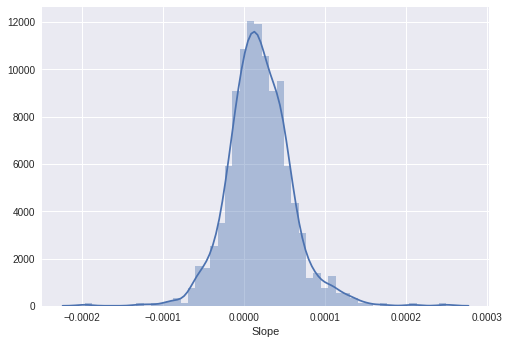

In [77]:
import matplotlib.pyplot as plt
import seaborn as sns

#df.hist(column='Slope', bins=20)
sns.distplot(df['Slope'])
plt.show()

In [88]:
sorted_by_slope[['Category', 'Slope', 'Bias-2000', 'Bias-Current', 'Filtered']].head(10)

,Category,Slope,Bias-2000,Bias-Current,Filtered
948,951 benefactor,-0.000197,0.011641,0.000003,auxiliary|auxiliary|benefactor|savior
453,455 purple,-0.000129,-0.029562,-0.034672,amethyst|amethyst|bishop|colored|heliotrope|la...
397,399 refrigerator,-0.000114,-0.015509,-0.002305,acetone|acetone|cooler|damper|freezer|ice|iceb...
318,320 plunge,-0.000097,-0.011755,-0.001586,bathe|bathe|dip|dive|diver|duck|ducking|engulf...
366,368 organization,-0.000092,-0.006731,-0.008863,albumen|albumen|anatomy|bacteriology|biology|b...
740,743 defiance,-0.000091,-0.001920,0.016505,beard|beard|beating|bluster|brave|cartel|chall...
362,364 pulpiness,-0.000084,-0.012621,-0.010180,curd|dough|jam|mush|oatmeal|pap|poultice|puddi...
297,299 repulsion,-0.000081,-0.008373,-0.010773,abduct|abduction|centripetal|chase|dispel|repe...
363,365 unctuousness,-0.000080,-0.014083,0.000015,adipose|adipose|fat|fatty|greasy|lubricate|lub...
384,386 sexuality,-0.000070,-0.021468,-0.009232,abuse|abuse|adultery|arousal|attractiveness|bi...


In [89]:
sorted_by_slope[['Category', 'Slope', 'Bias-2000', 'Bias-Current', 'Filtered']].tail(10)

,Category,Slope,Bias-2000,Bias-Current,Filtered
383,385 woman,0.000130,-0.027772,-0.064392,adolescence|adolescence|betty|bitch|consanguin...
940,943 celibacy,0.000130,-0.030203,-0.053498,bachelor|celibacy|coelebs|girl|maid|maiden|mai...
932,935 love,0.000136,-0.005190,-0.013007,admiration|admirer|adorable|adoration|adore|ad...
966,969 respect,0.000136,0.009138,0.018058,admiration|admiration|approbation|attention|aw...
746,749 peace,0.000137,0.008376,0.011772,accord|accord|amity|bloodless|calm|concord|dov...
507,509 credulity,0.000149,-0.003025,0.005101,believing|bigotry|childish|confiding|credulity...
916,919 modesty,0.000151,0.004487,0.005093,bashful|bashful|bashfulness|blush|blushing|con...
640,643 of motive,0.000171,0.006483,0.016223,aimless|aimlessness|caprice|capricious|chance|...
999,1002 purity,0.000208,-0.002764,-0.020111,chaste|chaste|chastity|cherry|continence|conti...
952,955 condolence,0.000249,0.016632,-0.002922,condolence|consolation|console|lament|lamentat...


# Sorted By 2K Bias

/home/moamin/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


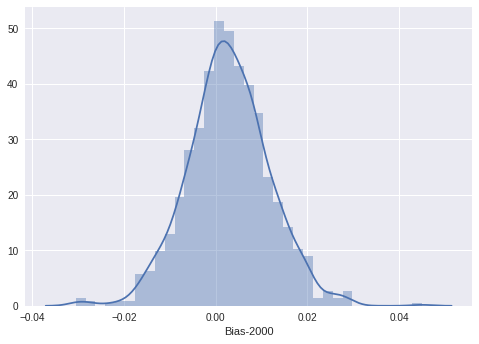

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns

#df.hist(column='Bias-2000', bins=20)
sns.distplot(df['Bias-2000'])
plt.show()

In [90]:
sorted_by_2k_bias[['Category', 'Slope', 'Bias-2000', 'Bias-Current', 'Filtered']].head(10)

,Category,Slope,Bias-2000,Bias-Current,Filtered
334,336 inelasticity,0.000054,-0.030510,0.012924,inelastic|inelasticity|inflexible|soft|softnes...
940,943 celibacy,0.000130,-0.030203,-0.053498,bachelor|celibacy|coelebs|girl|maid|maiden|mai...
453,455 purple,-0.000129,-0.029562,-0.034672,amethyst|amethyst|bishop|colored|heliotrope|la...
383,385 woman,0.000130,-0.027772,-0.064392,adolescence|adolescence|betty|bitch|consanguin...
934,937 favorite,-0.000024,-0.027099,-0.015466,crony|darling|dear|duck|favorite|fondling|hone...
941,944 divorce,0.000089,-0.023108,-0.041968,annulment|annulment|breakup|cuckold|divorce|di...
384,386 sexuality,-0.000070,-0.021468,-0.009232,abuse|abuse|adultery|arousal|attractiveness|bi...
387,389 pleasure,0.000040,-0.020495,-0.008628,agreeable|agreeable|clover|comfort|comfortable...
443,445 semitransparency,-0.000007,-0.018947,-0.026120,cloud|cloud|film|frosted|gauze|mica|milky|mist...
856,859 sensibility,0.000060,-0.017848,-0.006902,enthusiastic|excitability|excitable|expressive...


In [91]:
sorted_by_2k_bias[['Category', 'Slope', 'Bias-2000', 'Bias-Current', 'Filtered']].tail(10)

,Category,Slope,Bias-2000,Bias-Current,Filtered
808,811 possessor,0.000070,0.025932,0.009833,beneficiary|beneficiary|cestui|devisee|feoffee...
647,650 pursuit,0.000026,0.026245,0.014494,adventure|after|angling|begin|business|chase|c...
715,718 agent,0.000039,0.026399,0.023534,actor|actor|agent|ant|architect|artificer|arti...
1010,1013 condemnation,0.000025,0.027715,0.012146,accuse|accuse|attainder|attaint|cast|condemn|c...
785,788 consignee,0.000059,0.027774,0.016899,advocate|advocate|affaires|agent|ambassador|ar...
725,728 proficient,0.000053,0.027828,0.026312,acrobat|acrobat|adept|conjuror|connoisseur|dab...
1007,1010 lawyer,0.000028,0.028460,0.018599,advocate|advocate|attorney|bar|barrister|bench...
781,784 prisoner,0.000127,0.028608,-0.005085,captive|capture|hostage|imprisoned|inmate|pow|...
1033,1036 judeo-christian revelation,0.000010,0.029682,0.013759,acts|acts|afflatus|apocalypse|apocalyptic|apoc...
169,171 producer,0.000026,0.044912,0.028751,agent|agent|architect|author|creator|founder|g...


# Sorted By Current Bias

/home/moamin/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


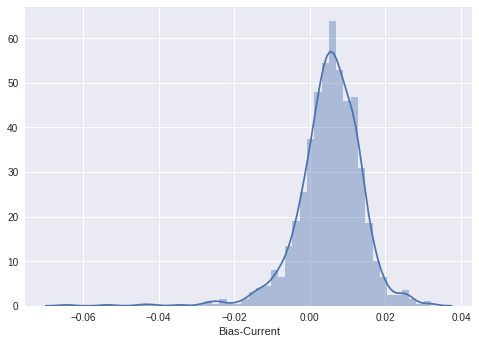

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns

#df.hist(column='Bias-Current', bins=20)
sns.distplot(df['Bias-Current'])
plt.show()

In [92]:
sorted_by_current_bias[['Category', 'Slope', 'Bias-2000', 'Bias-Current', 'Filtered']].head(10)

,Category,Slope,Bias-2000,Bias-Current,Filtered
383,385 woman,0.000130,-0.027772,-0.064392,adolescence|adolescence|betty|bitch|consanguin...
940,943 celibacy,0.000130,-0.030203,-0.053498,bachelor|celibacy|coelebs|girl|maid|maiden|mai...
412,414 inodorousness,0.000008,0.000000,-0.044421,inodorous|scentless
941,944 divorce,0.000089,-0.023108,-0.041968,annulment|annulment|breakup|cuckold|divorce|di...
453,455 purple,-0.000129,-0.029562,-0.034672,amethyst|amethyst|bishop|colored|heliotrope|la...
1001,1004 libertine,0.000041,-0.002406,-0.028231,adulterer|adulterer|adulteress|aspasia|baggage...
882,885 jewelry,-0.000017,-0.006772,-0.026973,agate|agate|amethyst|beryl|bijou|bracelet|bril...
443,445 semitransparency,-0.000007,-0.018947,-0.026120,cloud|cloud|film|frosted|gauze|mica|milky|mist...
939,942 marriage,0.000109,-0.011790,-0.025288,affiance|affiance|affianced|ally|baron|bed|ben...
413,415 fragrance,0.000016,-0.011476,-0.023787,after|after|aloes|ambrosial|aroma|aromatic|att...


In [93]:
sorted_by_current_bias[['Category', 'Slope', 'Bias-2000', 'Bias-Current', 'Filtered']].tail(10)

,Category,Slope,Bias-2000,Bias-Current,Filtered
892,895 laughingstock,0.000062,0.019992,0.025209,actor|actor|buffoon|butt|dupe|game|jest|jester...
947,950 misanthropy,0.000031,0.014767,0.025406,antisocial|antisocial|cynic|cynicism|diogenes|...
513,515 scholar,0.000034,0.013485,0.025667,academician|academician|antiquarian|antiquary|...
826,829 merchant,0.000069,0.015114,0.025851,agent|agent|autolycus|banker|bear|broker|bull|...
725,728 proficient,0.000053,0.027828,0.026312,acrobat|acrobat|adept|conjuror|connoisseur|dab...
536,538 analogy,0.000076,0.012037,0.026649,analogical|analogical|analogy|association|meta...
922,925 blusterer,-0.000028,0.003666,0.027041,bantam|bantam|blusterer|boaster|braggart|brawl...
169,171 producer,0.000026,0.044912,0.028751,agent|agent|architect|author|creator|founder|g...
546,548 interpreter,0.000044,0.014456,0.031679,annotator|annotator|cicerone|commentator|couri...
514,516 ignoramus,0.000022,0.009778,0.031997,amateur|amateur|asshole|bungler|charlatan|dabb...


# Scatter Plot of Biases

/home/moamin/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


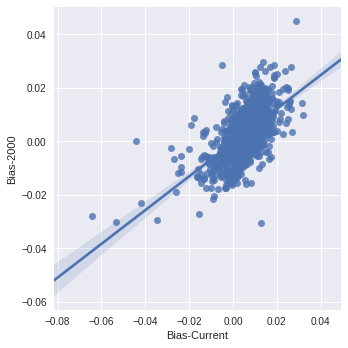

In [80]:
import matplotlib.pyplot as plt
import seaborn as sns

#df.plot.scatter(x='Bias-Current', y='Bias-2000', c='DarkBlue', title='Scatterplot')
sns.lmplot(x='Bias-Current', y='Bias-2000', data=df, fit_reg=True) 
plt.show()

# Compare to 1910

In [ ]:
currt = time.time()
dataset = []
count = 1

for i in range(0, len(roget_list_score)):
    if len(roget_list_score[i]) == 5 and roget_list_score[i][0].startswith("class"):
        roget_words = "|".join(x for x in roget_list_score[i][1])
        refined_words = "|".join(x for x in roget_list_score[i][2])
        slope = roget_list_score[i][3][0][2]
        bias = roget_list_score[i][4][0][10]
        
        refined_list = roget_list_score[i][2]
        fasttext_profile_lang.analyze_roget_words(refined_list)
        fasttext_bias_dic = fasttext_profile_lang.create_data_store_stats()
        fasttext_bias = list(fasttext_bias_dic.values())[0]
        
        dataset.append([roget_list_score[i][0].split("#")[-1], slope, bias, fasttext_bias, refined_words, roget_words])
        print(dataset[-1][0])
    
now = time.time()
print("Total time: ", len(dataset), (now-currt)/60)

In [96]:
import pandas as pd

dx = pd.DataFrame(dataset,columns=['Category','Slope', 'Bias-1910', 'Bias-Current', 'Filtered', 'Roget'])
sorted_by_1910_bias = dx.sort_values(by=['Bias-1910'])

/home/moamin/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


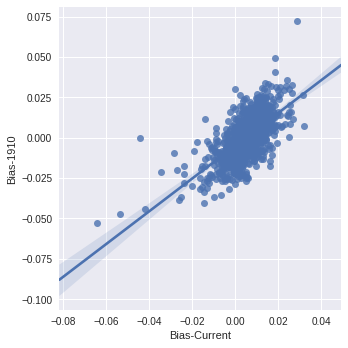

In [97]:
import matplotlib.pyplot as plt
import seaborn as sns

#df.plot.scatter(x='Bias-Current', y='Bias-2000', c='DarkBlue', title='Scatterplot')
sns.lmplot(x='Bias-Current', y='Bias-1910', data=dx, fit_reg=True) 
plt.show()

/home/moamin/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


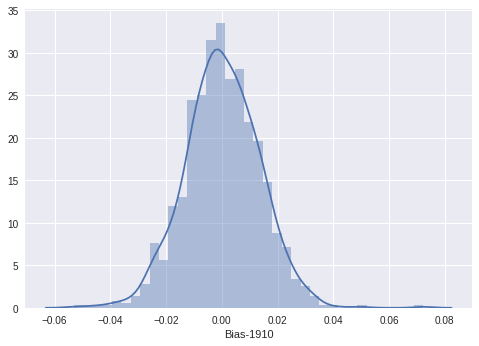

In [98]:
import matplotlib.pyplot as plt
import seaborn as sns

#df.hist(column='Bias-2000', bins=20)
sns.distplot(dx['Bias-1910'])
plt.show()

In [100]:
sorted_by_1910_bias[['Category', 'Slope', 'Bias-1910', 'Bias-Current', 'Filtered']].head(10)

,Category,Slope,Bias-1910,Bias-Current,Filtered
383,385 woman,1.295797e-04,-0.053033,-0.064392,adolescence|adolescence|betty|bitch|consanguin...
940,943 celibacy,1.304692e-04,-0.047135,-0.053498,bachelor|celibacy|coelebs|girl|maid|maiden|mai...
941,944 divorce,8.926892e-05,-0.043941,-0.041968,annulment|annulment|breakup|cuckold|divorce|di...
439,441 shade,3.781995e-05,-0.040255,-0.014492,awning|awning|blind|chick|cloud|cover|curtain|...
443,445 semitransparency,-6.603471e-06,-0.038550,-0.026120,cloud|cloud|film|frosted|gauze|mica|milky|mist...
939,942 marriage,1.085429e-04,-0.037051,-0.025288,affiance|affiance|affianced|ally|baron|bed|ben...
419,421 faintness,4.789083e-05,-0.036907,-0.009948,aside|aside|babble|breath|breathe|dulcet|dull|...
239,241 edge,-9.088736e-07,-0.035328,-0.006382,border|border|brim|brink|brow|chaps|chops|coas...
133,135 infant,4.453898e-05,-0.033395,-0.014452,aurelia|babe|baby|bairn|bambino|bantling|boy|b...
952,955 condolence,2.493514e-04,-0.032022,-0.002922,condolence|consolation|console|lament|lamentat...


In [101]:
sorted_by_1910_bias[['Category', 'Slope', 'Bias-1910', 'Bias-Current', 'Filtered']].tail(10)

,Category,Slope,Bias-1910,Bias-Current,Filtered
521,523 sage,0.000028,0.031581,0.021051,all|all|authority|emeritus|expert|genius|intel...
785,788 consignee,0.000059,0.032044,0.016899,advocate|advocate|affaires|agent|ambassador|ar...
715,718 agent,0.000039,0.032070,0.023534,actor|actor|agent|ant|architect|artificer|arti...
536,538 analogy,0.000076,0.032842,0.026649,analogical|analogical|analogy|association|meta...
617,620 dissertation,0.000038,0.033327,0.015326,article|article|commentary|commentator|conside...
1033,1036 judeo-christian revelation,0.000010,0.033750,0.013759,acts|acts|afflatus|apocalypse|apocalyptic|apoc...
926,929 enemy,-0.000056,0.035932,0.024053,antagonist|antagonist|enemy|foe|foeman|opponent
1007,1010 lawyer,0.000028,0.040640,0.018599,advocate|advocate|attorney|bar|barrister|bench...
832,835 treasurer,0.000021,0.049435,0.018522,accountant|accountant|almoner|banker|bursar|ca...
169,171 producer,0.000026,0.072251,0.028751,agent|agent|architect|author|creator|founder|g...
